Всего сэмплов: 1000
Хороших сэмплов (is_good=1): 735 (73.50%)
Плохих сэмплов (is_good=0): 265 (26.50%)
Веса классов: good=0.680, bad=1.887
Epoch 1/100 | Train Loss: 1.82471 | Val Loss: 1.80877 | LR: 0.001000
Validation loss improved to 1.80877. Saving model...
Validation loss improved to 1.66108. Saving model...
Validation loss improved to 1.52016. Saving model...
Validation loss improved to 1.43499. Saving model...
Validation loss improved to 1.40057. Saving model...
Validation loss improved to 1.38666. Saving model...
Validation loss improved to 1.37988. Saving model...
Validation loss improved to 1.37459. Saving model...
Validation loss improved to 1.37056. Saving model...
Epoch 10/100 | Train Loss: 1.27337 | Val Loss: 1.36585 | LR: 0.001000
Validation loss improved to 1.36585. Saving model...
Validation loss improved to 1.35814. Saving model...
Validation loss improved to 1.35076. Saving model...
Validation loss improved to 1.34218. Saving model...
Validation loss improved to 1.336

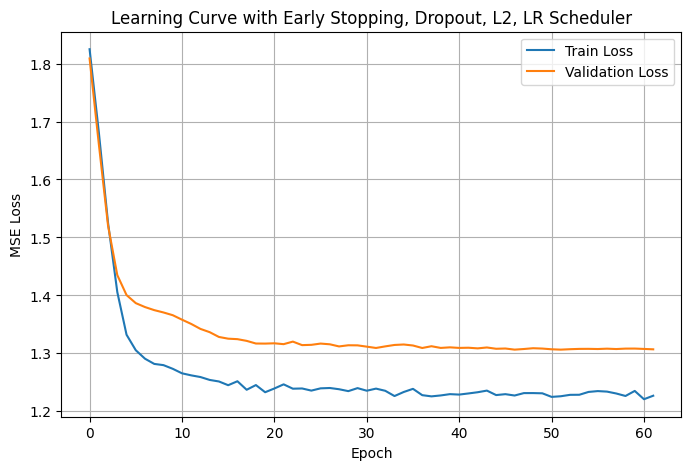


--- Метрики валидация ---
MAE (Kp, Ki): [0.7507442  0.46122694]
RMSE (Kp, Ki): [0.86969846 0.54154235]

--- Метрики тест ---
MAE (Kp, Ki): [0.76148564 0.49785018]
RMSE (Kp, Ki): [0.8568874 0.5754604]


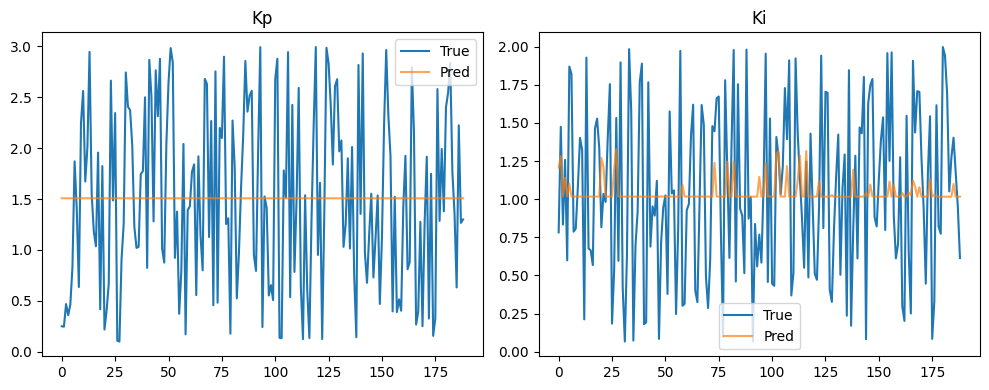

Обучение завершено. Модель и параметры нормализации сохранены в neuro_param_selector.pt


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import matplotlib.pyplot as plt

# Загрузка и нормализация данных
data = np.load('train_data_simulated_checked.npz')
X = data['X_train']
y = data['y_train']

is_good = X[:, -1]

num_good = np.sum(is_good == 1)
num_bad = np.sum(is_good == 0)
total = len(is_good)

print(f"Всего сэмплов: {total}")
print(f"Хороших сэмплов (is_good=1): {num_good} ({num_good/total:.2%})")
print(f"Плохих сэмплов (is_good=0): {num_bad} ({num_bad/total:.2%})")

# Автоматический расчет весов для балансировки классов
weight_bad = total / (2 * num_bad) if num_bad > 0 else 1.0
weight_good = total / (2 * num_good) if num_good > 0 else 1.0

print(f"Веса классов: good={weight_good:.3f}, bad={weight_bad:.3f}")

# В целевых данных остаются только Kp и Ki
y = y[:, :2]

# Фильтрация по диапазонам Kp и Ki
Kp_min, Kp_max = 0.1, 3.0
Ki_min, Ki_max = 0.05, 2.0
mask = (
    (y[:, 0] >= Kp_min) & (y[:, 0] <= Kp_max) &
    (y[:, 1] >= Ki_min) & (y[:, 1] <= Ki_max)
)
X = X[mask]
y = y[mask]

# Нормализация данных (min-max для X, стандартная для y)
X_min, X_max = X.min(axis=0), X.max(axis=0)
X_norm = (X - X_min) / (X_max - X_min + 1e-8)

y_mean, y_std = y.mean(axis=0), y.std(axis=0)
y_norm = (y - y_mean) / (y_std + 1e-8)

# Преобразование в тензоры
X_tensor = torch.tensor(X_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_norm, dtype=torch.float32)

# Разделение на обучающую, валидационную и тестовую выборки
val_ratio, test_ratio = 0.2, 0.1
N = len(X_tensor)
N_test = int(N * test_ratio)
N_val = int(N * val_ratio)
N_train = N - N_val - N_test

dataset = TensorDataset(X_tensor, y_tensor)
train_set, val_test_set = random_split(dataset, [N_train, N_val + N_test])
val_set, test_set = random_split(val_test_set, [N_val, N_test])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Определение нейросети
class ParamNet(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_p=0.25):
        super(ParamNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(32, output_dim),
            nn.Softplus() # гарантирует положительные выходы
        )
    def forward(self, x):
        return self.net(x)

input_dim = X_tensor.shape[1]
output_dim = 2  # Kp и Ki
model = ParamNet(input_dim, output_dim, dropout_p=0.25)

# Настройка обучения
loss_fn = nn.MSELoss(reduction='none') # поэлементный MSE
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.verbose = verbose
        self.best_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.5f}. Saving model...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement in validation loss for {self.counter} epochs.")
            if self.counter >= self.patience:
                self.early_stop = True

# Обучение модели
num_epochs = 100
penalty_coef = 1.0  # штраф за плохие сэмплы
train_losses, val_losses = [], []
early_stopping = EarlyStopping(patience=15, min_delta=1e-4, verbose=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        is_good = batch_X[:, -1]
        weights = torch.where(is_good > 0.5, torch.full_like(is_good, weight_good), torch.full_like(is_good, weight_bad))
        loss = loss_fn(outputs, batch_y).mean(dim=1)
        penalty = penalty_coef * (1 - is_good)
        total_loss = (loss * weights + penalty).mean()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item() * batch_X.size(0)
    epoch_loss /= N_train
    train_losses.append(epoch_loss)

    # Валидация
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X)
            is_good = batch_X[:, -1]
            weights = torch.where(is_good > 0.5, torch.full_like(is_good, weight_good), torch.full_like(is_good, weight_bad))
            loss = loss_fn(outputs, batch_y).mean(dim=1)
            penalty = penalty_coef * (1 - is_good)
            total_loss = (loss * weights + penalty).mean()
            val_loss += total_loss.item() * batch_X.size(0)
    val_loss /= N_val
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if (epoch+1) % 10 == 0 or epoch == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.5f} | Val Loss: {val_loss:.5f} | LR: {current_lr:.6f}")

    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Восстановление лучшиих весов модели
if early_stopping.best_state is not None:
    model.load_state_dict(early_stopping.best_state)

# Визуализация кривых обучения
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Learning Curve with Early Stopping, Dropout, L2, LR Scheduler')
plt.legend()
plt.grid()
plt.show()

# Функция для подсчёта метрик
def compute_metrics(X_data, y_data, model, X_min, X_max, y_mean, y_std, label=""):
    model.eval()
    with torch.no_grad():
        preds = model(X_data).cpu().numpy()
        true = y_data.cpu().numpy()
        preds_denorm = preds * y_std + y_mean
        true_denorm = true * y_std + y_mean

        mae = np.mean(np.abs(preds_denorm - true_denorm), axis=0)
        rmse = np.sqrt(np.mean((preds_denorm - true_denorm) ** 2, axis=0))

        print(f"\n--- Метрики {label} ---")
        print(f"MAE (Kp, Ki): {mae}")
        print(f"RMSE (Kp, Ki): {rmse}")

# Вычисление метрик на валидации и тесте
X_val = X_tensor[N_train:N_train+N_val]
y_val = y_tensor[N_train:N_train+N_val]
compute_metrics(X_val, y_val, model, X_min, X_max, y_mean, y_std, label="валидация")

X_test = X_tensor[N_train+N_val:]
y_test = y_tensor[N_train+N_val:]
compute_metrics(X_test, y_test, model, X_min, X_max, y_mean, y_std, label="тест")

# Визуализация предсказаний на валидации
model.eval()
with torch.no_grad():
    preds = model(X_val).cpu().numpy()
    true = y_val.cpu().numpy()
    preds_denorm = preds * y_std + y_mean
    true_denorm = true * y_std + y_mean

plt.figure(figsize=(10, 4))
param_names = ['Kp', 'Ki']
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.plot(true_denorm[:, i], label='True')
    plt.plot(preds_denorm[:, i], label='Pred', alpha=0.7)
    plt.title(param_names[i])
    plt.legend()
plt.tight_layout()
plt.show()

# Сохранение модели и параметров нормализации
torch.save({
    'model_state_dict': model.state_dict(),
    'X_min': X_min,
    'X_max': X_max,
    'y_mean': y_mean,
    'y_std': y_std
}, 'neuro_param_selector.pt')
print("Обучение завершено. Модель и параметры нормализации сохранены в neuro_param_selector.pt")
